Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [34]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Change me to store data elsewhere
data_root = '.'

alpha_map = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# Define function to plot dataset
def plot_dataset(dataset, labels, name = ""):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(name, fontsize=12)
    for i, j in enumerate(np.random.randint(0, dataset.shape[0], size=20)):
        x = dataset[j]
        y = labels[j]
        subplot = plt.subplot(6,20,i + 1)
        subplot.set_xticks(())
        subplot.set_yticks(())
        subplot.set_title(alpha_map[y])
        subplot.imshow(x, cmap='gray')
    plt.show()

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [35]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [36]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

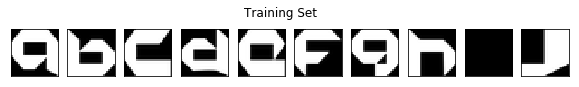

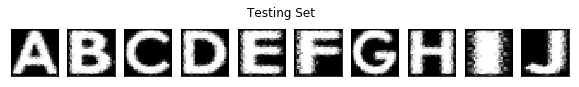

In [37]:
from PIL import Image

fig = plt.figure(figsize=(10, 3))
fig.suptitle('Training Set', fontsize=12)
for i in range(len(train_folders)):
    train_folder = train_folders[i]
    subplot = plt.subplot(3,10,i + 1)
    subplot.set_xticks(())
    subplot.set_yticks(())
    img = Image.open(train_folder + '/' + os.listdir(train_folder)[0])
    subplot.imshow(img, cmap='gray')

fig = plt.figure(figsize=(10, 3))
fig.suptitle('Testing Set', fontsize=12)
for i in range(len(test_folders)):
    test_folder = test_folders[i]
    subplot = plt.subplot(3,10,i + 1)
    subplot.set_xticks(())
    subplot.set_yticks(())
    img = Image.open(test_folder + '/' + os.listdir(test_folder)[0])
    subplot.imshow(img, cmap='gray')
plt.show()

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [40]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (np.asarray(Image.open(image_file)).astype(float)  - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

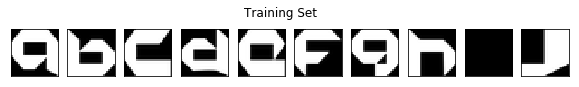

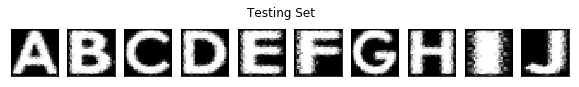

In [42]:
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Training Set', fontsize=12)
for i in range(len(train_datasets)):
    train_set = train_datasets[i]
    with open(train_set, 'rb') as f:
        ts = pickle.loads(f.read())
        subplot = plt.subplot(3,10,i + 1)
        subplot.set_xticks(())
        subplot.set_yticks(())
        subplot.imshow(ts[0], cmap='gray')

fig = plt.figure(figsize=(10, 3))
fig.suptitle('Testing Set', fontsize=12)
for i in range(len(test_datasets)):
    test_set = test_datasets[i]
    with open(test_set, 'rb') as f:
        ts = pickle.loads(f.read())
        subplot = plt.subplot(3,10,i + 1)
        subplot.set_xticks(())
        subplot.set_yticks(())
        subplot.imshow(ts[0], cmap='gray')
plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [43]:
for train_set in train_datasets:
    with open(train_set, 'rb') as f:
        ts = pickle.loads(f.read())
        print(ts.shape)

for test_set in test_datasets:
    with open(test_set, 'rb') as f:
        ts = pickle.loads(f.read())
        print(ts.shape)

(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [44]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [45]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

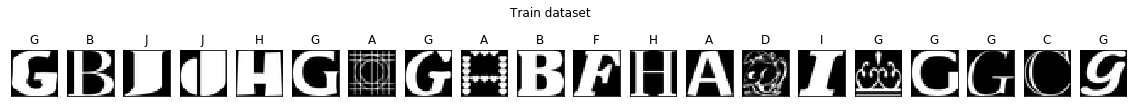

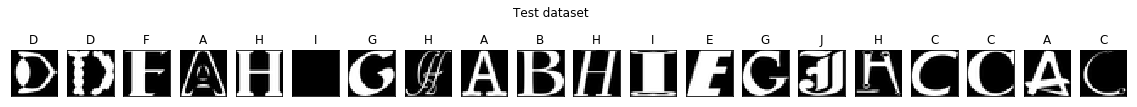

In [46]:
plot_dataset(train_dataset, train_labels, "Train dataset")
plot_dataset(test_dataset, test_labels, "Test dataset")

Finally, let's save the data for later reuse:

In [47]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [48]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [2]:
# Load non-deduped datasets from files

pickle_file = os.path.join(data_root, 'notMNIST.pickle')
train_dataset = None
train_labels = None
valid_dataset = None
valid_labels = None
test_dataset = None
test_labels = None
with open(pickle_file, 'r') as f:
    save = pickle.loads(f.read())
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']

# plot_dataset(train_dataset, train_labels, "Train dataset")
# plot_dataset(valid_dataset, valid_labels, "Validation dataset")
# plot_dataset(test_dataset, test_labels, "Test dataset")

print("Successfully loaded files.")

Successfully loaded files.


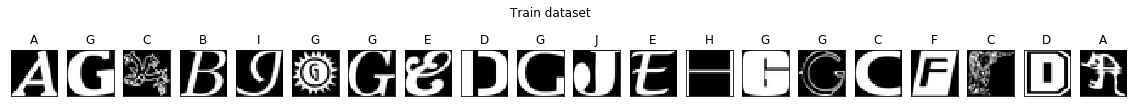

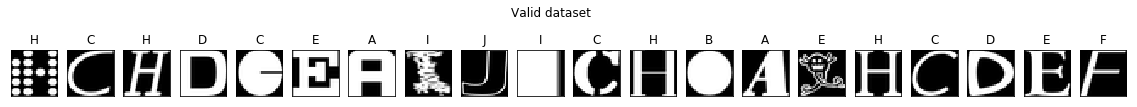

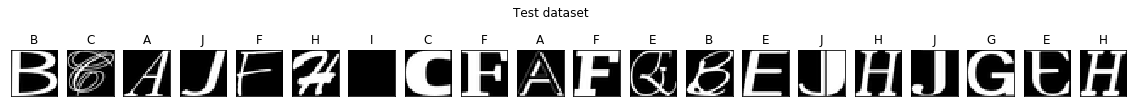

In [4]:
# Sanity check files by viewing them
plot_dataset(train_dataset, train_labels, "Train dataset")
plot_dataset(valid_dataset, valid_labels, "Valid dataset")
plot_dataset(test_dataset, test_labels, "Test dataset")

In [7]:
# Define function for counting duplicates in train, valid, and test sets

def cmpArr(a1, a2, debug = False):
    if np.array_equal(a1, a2):
        if debug:
            plt.imshow(a1)
            plt.show()
            plt.imshow(a2)
            plt.show()
            print("-----------------------------\n")
        return 0
    
    for i in range(a1.shape[0]):
        for j in range(a1.shape[1]):
            if a1[i][j] < a2[i][j]:
                return -1
            elif a1[i][j] > a2[i][j]:
                return 1

def find_dupes(train_dataset, valid_dataset, test_dataset, debug=False):
    enumerated_train_dataset = []
    enumerated_valid_dataset = []
    enumerated_test_dataset = []
    
    for (i,x) in enumerate(train_dataset):
        enumerated_train_dataset.append((i, x))
    for (i,x) in enumerate(valid_dataset):
        enumerated_valid_dataset.append((i, x))
    for (i,x) in enumerate(test_dataset):
        enumerated_test_dataset.append((i, x))
    
    def cmpArrSort(x1, x2):
        return cmpArr(x1[1], x2[1])
    
    enumerated_sorted_train = sorted(enumerated_train_dataset, cmp = cmpArrSort)
    enumerated_sorted_valid = sorted(enumerated_valid_dataset, cmp = cmpArrSort)
    enumerated_sorted_test = sorted(enumerated_test_dataset, cmp = cmpArrSort)

    overlap_train_valid = 0
    overlap_train_test = 0
    overlap_valid_test = 0

    train_dataset_remove = set()
    valid_dataset_remove = set()
    test_dataset_remove = set()
    
    duplicate_pictures = []

    i = 0
    j = 0
    while i < len(enumerated_sorted_train) and j < len(enumerated_sorted_valid):
        compare = cmpArr(enumerated_sorted_train[i][1], enumerated_sorted_valid[j][1], debug=debug)
        if compare == 0:
            train_dataset_remove.add(enumerated_sorted_train[i][0])
            valid_dataset_remove.add(enumerated_sorted_valid[j][0])
            duplicate_pictures.append((enumerated_sorted_train[i][0], enumerated_sorted_valid[j][0], -1))
            i += 1
            j += 1
            overlap_train_valid += 1
            continue
        elif compare == -1:
            i += 1
        elif compare == 1:
            j += 1

    i = 0
    j = 0
    while i < len(enumerated_sorted_train) and j < len(enumerated_sorted_test):
        compare = cmpArr(enumerated_sorted_train[i][1], enumerated_sorted_test[j][1], debug=debug)
        if compare == 0:
            train_dataset_remove.add(enumerated_sorted_train[i][0])
            test_dataset_remove.add(enumerated_sorted_test[j][0])
            duplicate_pictures.append((enumerated_sorted_train[i][0], -1, enumerated_sorted_test[j][0]))
            i += 1
            j += 1
            overlap_train_test += 1
            train_dataset_remove.add(i)
            continue
        elif compare == -1:
            i += 1
        elif compare == 1:
            j += 1

    i = 0
    j = 0
    while i < len(enumerated_sorted_valid) and j < len(enumerated_sorted_test):
        compare = cmpArr(enumerated_sorted_valid[i][1], enumerated_sorted_test[j][1], debug=debug)
        if compare == 0:
            valid_dataset_remove.add(enumerated_sorted_valid[i][0])
            test_dataset_remove.add(enumerated_sorted_test[j][0])
            duplicate_pictures.append((-1 ,enumerated_sorted_valid[i][0], enumerated_sorted_test[j][0]))
            i += 1
            j += 1
            overlap_valid_test += 1
            continue
        elif compare == -1:
            i += 1
        elif compare == 1:
            j += 1
    
    overlap = {'train_valid': overlap_train_valid, 'train_test': overlap_train_test, 'valid_test': overlap_valid_test}
    remove_indices = {'train': train_dataset_remove, 'valid': valid_dataset_remove, 'test': test_dataset_remove}
    return overlap, remove_indices, duplicate_pictures

In [4]:
overlap, remove_indices, duplicate_pictures = find_dupes(train_dataset, valid_dataset, test_dataset)
print("Overlap between train and valid datasets: %d" % overlap['train_valid'])
print("Overlap between train and test datasets: %d" % overlap['train_test'])
print("Overlap between valid and test datasets: %d" % overlap['valid_test'])

Overlap between train and valid datasets: 1067
Overlap between train and test datasets: 1279
Overlap between valid and test datasets: 170


In [5]:
train_dataset_dedup = np.delete(train_dataset, list(remove_indices['train']), axis = 0)
valid_dataset_dedup = np.delete(valid_dataset, list(remove_indices['valid']), axis = 0)
test_dataset_dedup = np.delete(test_dataset, list(remove_indices['test']), axis = 0)
train_labels_dedup = np.delete(train_labels, list(remove_indices['train']), axis = 0)
valid_labels_dedup = np.delete(valid_labels, list(remove_indices['valid']), axis = 0)
test_labels_dedup = np.delete(test_labels, list(remove_indices['test']), axis = 0)

print("Successfully created deduped sets")

Successfully created deduped sets


In [6]:
# Save deduped train, valid, and test sets on a file
pickle_file = os.path.join(data_root, 'notMNIST_deduped.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_dedup,
    'train_labels': train_labels_dedup,
    'valid_dataset': valid_dataset_dedup,
    'valid_labels': valid_labels_dedup,
    'test_dataset': test_dataset_dedup,
    'test_labels': test_labels_dedup,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)

print("Saved deduped sets to ", pickle_file, '.')

Saved deduped sets to  ./notMNIST_deduped.pickle .


In [58]:
# Load deduped datasets from files

pickle_file = os.path.join(data_root, 'notMNIST_deduped.pickle')
datasets_deduped = None
with open(pickle_file, 'r') as f:
    datasets_deduped = pickle.loads(f.read())

print("Successfully loaded files for deduped datasets.")

Successfully loaded files for deduped datasets.


In [59]:
# load into proper variables
train_dataset_dedup = datasets_deduped['train_dataset']
train_labels_dedup = datasets_deduped['train_labels']
valid_dataset_dedup = datasets_deduped['valid_dataset']
valid_labels_dedup = datasets_deduped['valid_labels']
test_dataset_dedup = datasets_deduped['test_dataset']
test_labels_dedup = datasets_deduped['test_labels']

# check for dupes (sanity check)
# overlap, remove_indices, duplicate_pictures = find_dupes(train_dataset, valid_dataset, test_dataset)
# print("Overlap between train and valid datasets: %d" % overlap['train_valid'])
# print("Overlap between train and test datasets: %d" % overlap['train_test'])
# print("Overlap between valid and test datasets: %d" % overlap['valid_test'])

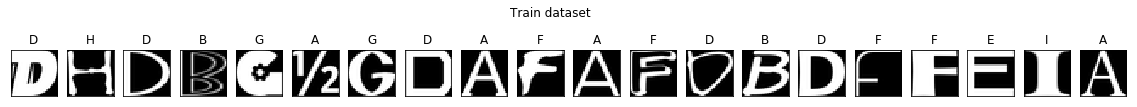

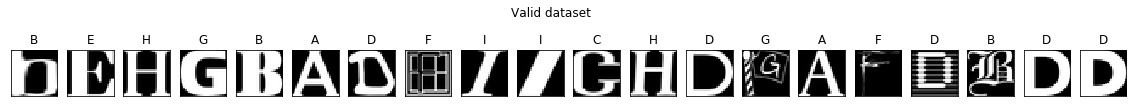

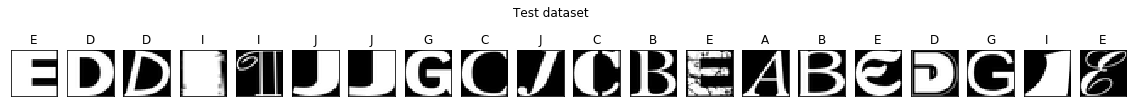

In [7]:
# Sanity check deduped files by viewing them
plot_dataset(train_dataset_dedup, train_labels_dedup, "Train dataset")
plot_dataset(valid_dataset_dedup, valid_labels_dedup, "Valid dataset")
plot_dataset(test_dataset_dedup, test_labels_dedup, "Test dataset")

In [5]:
# double dedupe sets by removing same pictures from each set
def find_dupe_within_set(dataset):
    enumerated_dataset = []
    
    for (i,x) in enumerate(dataset):
        enumerated_dataset.append((i,x))
    
    def cmpArrSort(x1, x2):
        return cmpArr(x1[1], x2[1])
    
    enumerated_sorted = sorted(enumerated_dataset, cmp = cmpArrSort)
    
    dataset_remove = set()
    overlap = 0
    
    last_unique = np.zeros(dataset[0].shape)
    for (i,this_img) in enumerated_sorted:
        if np.array_equal(last_unique, this_img):
            dataset_remove.add(i)
            overlap += 1
        else:
            last_unique = this_img
    
    return overlap, dataset_remove

In [8]:
o_train, remove_train = find_dupe_within_set(train_dataset_dedup)
o_valid, remove_valid = find_dupe_within_set(valid_dataset_dedup)
o_test, remove_test = find_dupe_within_set(test_dataset_dedup)

print("Duplicates within the training set:", o_train)
print("Duplicates within the validation set:", o_valid)
print("Duplicates within the testing set:", o_test)

Duplicates within the training set: 11938
Duplicates within the validation set: 28
Duplicates within the testing set: 58


In [14]:
remove_train_list = list(remove_train)
remove_valid_list = list(remove_valid)
remove_test_list = list(remove_test)

train_dataset_dedup2 = np.delete(train_dataset_dedup, remove_train_list, axis = 0)
train_labels_dedup2 = np.delete(train_labels_dedup, remove_train_list, axis = 0)
valid_dataset_dedup2 = np.delete(valid_dataset_dedup, remove_valid_list, axis = 0)
valid_labels_dedup2 = np.delete(valid_labels_dedup, remove_valid_list, axis = 0)
test_dataset_dedup2 = np.delete(test_dataset_dedup, remove_test_list, axis = 0)
test_labels_dedup2 = np.delete(test_labels_dedup, remove_test_list, axis = 0)

print("Successfully created deduped sets")

Successfully created deduped sets


In [15]:
print("Training Set Size:", train_dataset_dedup2.shape, train_labels_dedup2.shape)
print("Validation Set Size:", valid_dataset_dedup2.shape, valid_labels_dedup2.shape)
print("Testing Set Size:", test_dataset_dedup2.shape, test_labels_dedup2.shape)

Training Set Size: (184584, 28, 28) (184584,)
Validation Set Size: (8866, 28, 28) (8866,)
Testing Set Size: (8624, 28, 28) (8624,)


In [31]:
# Save double-deduped train, valid, and test sets on a file
pickle_file = os.path.join(data_root, 'notMNIST_deduped_double.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset_dedup2,
    'train_labels': train_labels_dedup2,
    'valid_dataset': valid_dataset_dedup2,
    'valid_labels': valid_labels_dedup2,
    'test_dataset': test_dataset_dedup2,
    'test_labels': test_labels_dedup2,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)

print("Saved double-deduped sets to ", pickle_file, '.')

Saved double-deduped sets to  ./notMNIST_deduped_double.pickle .


In [2]:
# Load double-deduped datasets from files

pickle_file = os.path.join(data_root, 'notMNIST_deduped_double.pickle')
datasets_double_deduped = None
with open(pickle_file, 'r') as f:
    datasets_double_deduped = pickle.loads(f.read())

print("Successfully loaded files for double deduped datasets.")

Successfully loaded files for double deduped datasets.


In [3]:
# load into proper variables
train_dataset_dedup2 = datasets_double_deduped['train_dataset']
train_labels_dedup2 = datasets_double_deduped['train_labels']
valid_dataset_dedup2 = datasets_double_deduped['valid_dataset']
valid_labels_dedup2 = datasets_double_deduped['valid_labels']
test_dataset_dedup2 = datasets_double_deduped['test_dataset']
test_labels_dedup2 = datasets_double_deduped['test_labels']

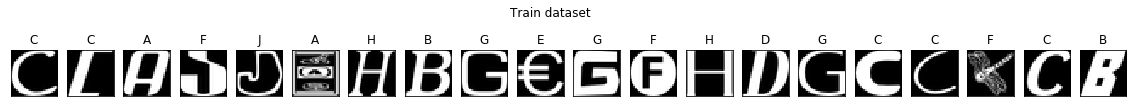

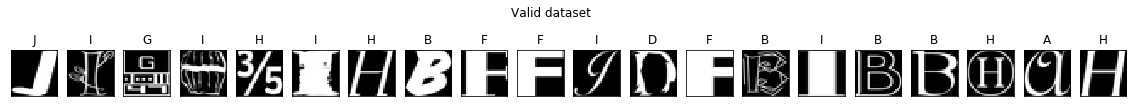

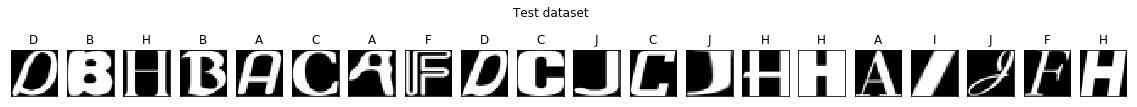

In [10]:
# Sanity check deduped files by viewing them
plot_dataset(train_dataset_dedup2, train_labels_dedup2, "Train dataset")
plot_dataset(valid_dataset_dedup2, valid_labels_dedup2, "Valid dataset")
plot_dataset(test_dataset_dedup2, test_labels_dedup2, "Test dataset")

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [4]:
solver = LogisticRegression(solver='sag', multi_class='multinomial', max_iter = 1000)

In [5]:
def reshape_dataset(dataset):
    return np.reshape(dataset, (dataset.shape[0], dataset.shape[1] * dataset.shape[2]))

In [6]:
reshaped_train_dataset = reshape_dataset(train_dataset)
reshaped_valid_dataset = reshape_dataset(valid_dataset)
reshaped_test_dataset = reshape_dataset(test_dataset)

NameError: name 'train_dataset' is not defined

In [37]:
solver.fit(reshaped_train_dataset[:50], train_labels[:50])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
def reshape_example(example):
    return np.reshape(example, (1,example.shape[0]))

In [49]:
valid_predict = solver.predict(reshaped_valid_dataset)
print("Accuracy:", np.sum(valid_predict == valid_labels) / float(len(valid_labels)))

Accuracy: 0.5932


In [50]:
solver.fit(reshaped_train_dataset[:100], train_labels[:100])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
valid_predict = solver.predict(reshaped_valid_dataset)
print("Accuracy:", np.sum(valid_predict == valid_labels) / float(len(valid_labels)))

Accuracy: 0.6645


In [53]:
solver.fit(reshaped_train_dataset[:1000], train_labels[:1000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
valid_predict = solver.predict(reshaped_valid_dataset)
print("Accuracy:", np.sum(valid_predict == valid_labels) / float(len(valid_labels)))

Accuracy: 0.7608


In [55]:
solver.fit(reshaped_train_dataset[:5000], train_labels[:5000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
valid_predict = solver.predict(reshaped_valid_dataset)
print("Accuracy:", np.sum(valid_predict == valid_labels) / float(len(valid_labels)))

Accuracy: 0.7703


In [60]:
reshaped_train_dataset_dedup = reshape_dataset(train_dataset_dedup)
reshaped_valid_dataset_dedup = reshape_dataset(valid_dataset_dedup)
reshaped_test_dataset_dedup = reshape_dataset(test_dataset_dedup)

In [61]:
solver.fit(reshaped_train_dataset_dedup[:1000], train_labels_dedup[:1000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
valid_predict_dedup = solver.predict(reshaped_valid_dataset_dedup)
print("Accuracy:", np.sum(valid_predict_dedup == valid_labels_dedup) / float(len(valid_labels_dedup)))

Accuracy: 0.752529795368


In [7]:
reshaped_train_dataset_dedup2 = reshape_dataset(train_dataset_dedup2)
reshaped_valid_dataset_dedup2 = reshape_dataset(valid_dataset_dedup2)
reshaped_test_dataset_dedup2 = reshape_dataset(test_dataset_dedup2)

In [8]:
solver.fit(reshaped_train_dataset_dedup2[:1000], train_labels_dedup2[:1000])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
train_predict_dedup2 = solver.predict(reshaped_train_dataset_dedup2)
print("Train accuracy:", np.sum(train_predict_dedup2 == train_labels_dedup2) / float(len(train_labels_dedup2)))

valid_predict_dedup2 = solver.predict(reshaped_valid_dataset_dedup2)
print("Valid accuracy:", np.sum(valid_predict_dedup2 == valid_labels_dedup2) / float(len(valid_labels_dedup2)))

test_predict_dedup2 = solver.predict(reshaped_test_dataset_dedup2)
print("Test accuracy:", np.sum(test_predict_dedup2 == test_labels_dedup2) / float(len(test_labels_dedup2)))

Train accuracy: 0.759204481429
Valid accuracy: 0.752312203925
Test accuracy: 0.821892393321


In [78]:
solver.fit(data.data, data.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
np.sum(solver.predict(data.data) == data.target) / float(len(data.target))

0.97999999999999998

In [21]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 5, 3), max_iter = 2000)
clf.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
train_predict_dedup2 = clf.predict(reshaped_train_dataset_dedup2)
print("Train accuracy:", np.sum(train_predict_dedup2 == train_labels_dedup2) / float(len(train_labels_dedup2)))

valid_predict_dedup2 = clf.predict(reshaped_valid_dataset_dedup2)
print("Valid accuracy:", np.sum(valid_predict_dedup2 == valid_labels_dedup2) / float(len(valid_labels_dedup2)))

test_predict_dedup2 = clf.predict(reshaped_test_dataset_dedup2)
print("Test accuracy:", np.sum(test_predict_dedup2 == test_labels_dedup2) / float(len(test_labels_dedup2)))

Train accuracy: 0.743043817449
Valid accuracy: 0.724791337695
Test accuracy: 0.808557513915


In [23]:
clf.score(reshaped_train_dataset_dedup2, train_labels_dedup2)

0.81998439734754913

In [24]:
clf.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2)

0.80036092939318748

In [25]:
clf.score(reshaped_test_dataset_dedup2, test_labels_dedup2)

0.87418831168831168

Examining example #7490
Predict answer: C
Correct answer: C
Confidence (prob of correct): 0.990749784745


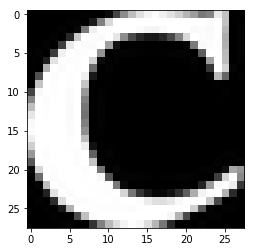

In [95]:
np.set_printoptions(suppress=True)
i = np.random.randint(0, reshaped_valid_dataset_dedup2.shape[0])
print("Examining example #%d" % i)
predict = np.squeeze(clf.predict(reshape_example(reshaped_valid_dataset_dedup2[i])))
print("Predict answer:", alpha_map[predict])
print("Correct answer:", alpha_map[valid_labels_dedup2[i]])
prob = np.squeeze(clf.predict_proba(reshape_example(reshaped_valid_dataset_dedup2[i])))
# print("Predict probabilities:", prob)
print("Confidence (prob of correct):", prob[predict])
plt.imshow(valid_dataset_dedup2[i], cmap='gray')
plt.show()

In [96]:
clf2 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(15, 10, 10, 5), max_iter = 2000)
clf2.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [97]:
print("Train accuracy:", clf2.score(reshaped_train_dataset_dedup2, train_labels_dedup2))
print("Valid accuracy:", clf2.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2))

Train accuracy: 0.867111992372
Valid accuracy: 0.848748026167


In [98]:
clf3 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 2000)
clf3.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5),
       learning_rate='constant', learning_rate_init=0.001, max_iter=2000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [99]:
print("Train accuracy:", clf3.score(reshaped_train_dataset_dedup2, train_labels_dedup2))
print("Valid accuracy:", clf3.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2))

Train accuracy: 0.866180167295
Valid accuracy: 0.84795849312


In [100]:
clf4 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 2000, learning_rate_init = 0.01)
clf4.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5),
       learning_rate='constant', learning_rate_init=0.01, max_iter=2000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [101]:
print("Train accuracy:", clf4.score(reshaped_train_dataset_dedup2, train_labels_dedup2))
print("Valid accuracy:", clf4.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2))

Train accuracy: 0.845707103541
Valid accuracy: 0.837130611324


In [111]:
clf5 = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 5000, learning_rate_init = 0.005)
clf5.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5),
       learning_rate='constant', learning_rate_init=0.005, max_iter=5000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [112]:
print("Train accuracy:", clf5.score(reshaped_train_dataset_dedup2, train_labels_dedup2))
print("Valid accuracy:", clf5.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2))

Train accuracy: 0.841324275127
Valid accuracy: 0.827769005188


In [113]:
clf6 = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 5000, learning_rate_init = 0.005, warm_start=True)
clf6.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5),
       learning_rate='constant', learning_rate_init=0.005, max_iter=5000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [114]:
print("Train accuracy:", clf6.score(reshaped_train_dataset_dedup2, train_labels_dedup2))
print("Valid accuracy:", clf6.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2))

Train accuracy: 0.860437524379
Valid accuracy: 0.842544552222


In [115]:
clf7 = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 5000, learning_rate_init = 0.005, warm_start=True)
clf7.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5),
       learning_rate='constant', learning_rate_init=0.005, max_iter=5000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [116]:
print("Train accuracy:", clf7.score(reshaped_train_dataset_dedup2, train_labels_dedup2))
print("Valid accuracy:", clf7.score(reshaped_valid_dataset_dedup2, valid_labels_dedup2))

Train accuracy: 0.858237983791
Valid accuracy: 0.843672456576


Examining example #4917
Predict answer: A
Correct answer: A
Confidence (prob of correct): 0.992988059443


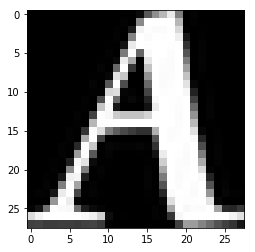

In [178]:
np.set_printoptions(suppress=True)
i = np.random.randint(0, reshaped_valid_dataset_dedup2.shape[0])
print("Examining example #%d" % i)
predict = np.squeeze(clf2.predict(reshape_example(reshaped_valid_dataset_dedup2[i])))
print("Predict answer:", alpha_map[predict])
print("Correct answer:", alpha_map[valid_labels_dedup2[i]])
prob = np.squeeze(clf.predict_proba(reshape_example(reshaped_valid_dataset_dedup2[i])))
# print("Predict probabilities:", prob)
print("Confidence (prob of correct):", prob[predict])
plt.imshow(valid_dataset_dedup2[i], cmap='gray')
plt.show()

In [ ]:
clf7 = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 5000, learning_rate_init = 0.005, batch_size = 512)
clf7.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=512, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5),
       learning_rate='constant', learning_rate_init=0.005, max_iter=5000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
clf8 = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(15, 10, 10, 10, 10, 10, 5), max_iter = 5000, learning_rate_init = 0.0001, batch_size = 512)
clf8.fit(reshaped_train_dataset_dedup2, train_labels_dedup2)